# Onsets

In [1]:
from maelzel.snd import features
from maelzel.snd import plotting, audiosample
import numpy as np
from maelzel.core import *
from pitchtools import *

import csoundengine as ce


In [2]:
samp = audiosample.Sample("snd/finneganswake-fragm01.flac").getChannel(0, contiguous=True)[0:10]

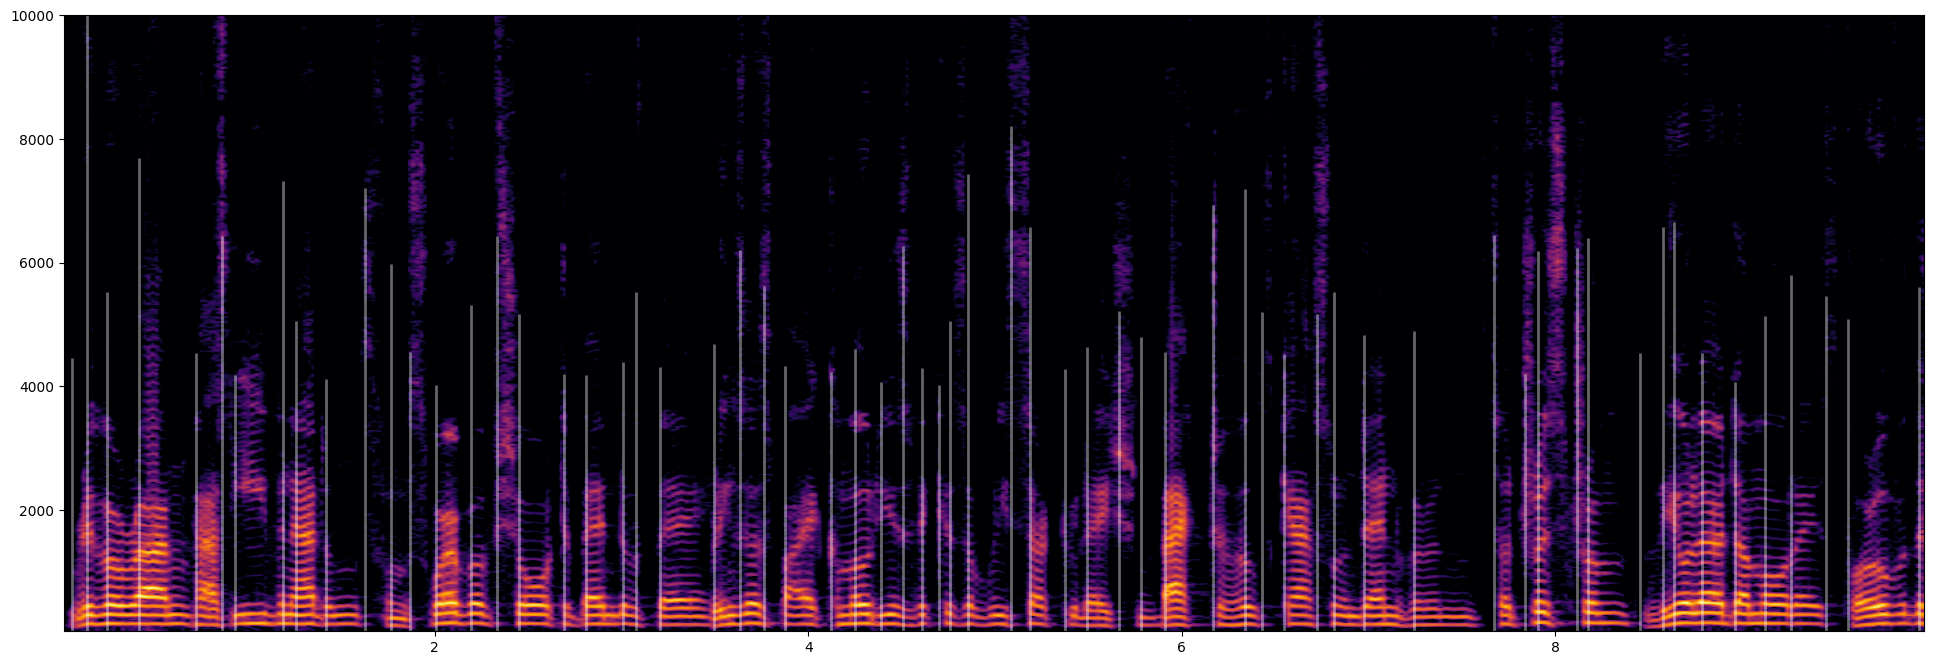

In [3]:
onsets, onsetStrength = features.onsets(samp.samples, sr=samp.sr, threshold=0.1, mingap=1/20, winsize=2048, hopsize=512)

ax = plotting.plotSpectrogram(samp.samples, samplerate=samp.sr, maxfreq=10000)

# Plot each onset as a vertical line
ymax = 4000 + onsetStrength.map(onsets)*2000
ax.vlines(onsets, ymin=0, ymax=ymax, color='white', alpha=0.4, linewidth=2)
# ax.vlines(onsets, ymin=0, ymax=10000, color='white', alpha=0.4, linewidth=2)

In [5]:
from maelzel.snd import freqestimate
freqbpf, voicedbpf = freqestimate.f0curvePyinVamp(sig=samp.samples, sr=samp.sr,  
                                                  onsetSensitivity=0.1, pruneThreshold=0.1, threshDistr='beta30', fftsize=2048, overlap=8)

mnOut size: 1723
m_pitchTrack size: 1723


In [6]:
ampcurve = samp.peaksbpf(overlap=4)
amps = ampcurve.map(onsets)
freqs = freqbpf.map(onsets+0.05)
freqs

array([133.70896099, 138.71817451, 146.10220983, 144.53897526,
       131.29447824,          nan, 151.8777628 , 145.52286312,
       145.10945321, 141.18967563,          nan, 113.13866524,
                nan, 160.02839901, 150.9491146 ,          nan,
       148.90165259, 114.38861077, 143.12479199, 135.52996901,
                nan, 130.52038078, 132.36367201, 158.66469533,
       148.62005293, 137.82237042, 142.03431479, 152.64739699,
       148.77930443, 119.39924001,          nan, 152.63909818,
                nan, 126.1425592 ,          nan, 141.2992621 ,
       133.16497013, 118.87802098,          nan, 118.71340534,
       131.99157506, 129.54742154, 128.63844634,          nan,
       144.45399201,          nan, 134.4237274 , 136.5260058 ,
       127.68244848, 141.81817108, 168.41336601, 149.59869481,
       165.81975308, 156.86782   ,  99.9391493 , 151.62572489,
       161.74751561, 160.94242409, 151.81803687, 152.78356236,
       148.37080027,          nan, 118.43149299,       

In [7]:
durs = np.empty_like(onsets)
durs[:-1] = onsets[1:] - onsets[:-1]
durs[-1] = durs[0]

Chain([3C+30:-20dB:0.081♩:offset=0, 3Db-06:-4dB:0.104♩:offset=0.081, 3D-16:-3dB:0.174♩:offset=0.186, 3D-35:-1dB:0.302♩:offset=0.36, 3C-01:-7dB:0.139♩:offset=0.662, 3C-01:-23dB:0.07♩:offset=0.801, 3Eb-49:-8dB:0.255♩:offset=0.871, 3D-23:-6dB:0.07♩:offset=1.126, 3D-28:-4dB:0.163♩:offset=1.196, 3C#+24:-7dB:0.209♩:offset=1.358, …])
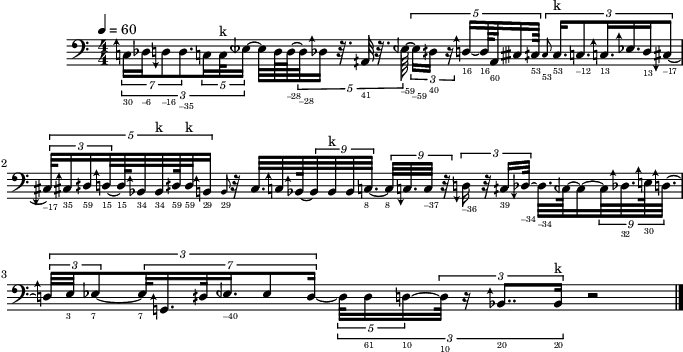

In [21]:
notes = []
minamp = db2amp(-25)
lastfreq = next(f for f in freqs if not np.isnan(f))
for freq, dur, amp in zip(freqs, durs, amps):
    if np.isnan(freq):
        note = Note(f2m(lastfreq), dur=dur, amp=amp, label='k') if amp > minamp else Rest(dur=dur)
        notes.append(note)
    else:
        notes.append(Note(f2m(freq), dur=dur, amp=amp**0.5))
        lastfreq = freq
voice = Chain(notes)
voice.stack()
voice

In [22]:
e = playback.playEngine()

with e:
    voice.play(gain=2, instr='piano', fade=(0, 0.5))
    e.session().playSample((samp.samples, samp.sr), pan=1)

## Sync with absolute time

The same score can be notated in any tempo or time signature. Notice that since we are synchronized to a real-time sample, it is not enough to just change the tempo. By changing the tempo the notes would play at the new tempo but the sample would stay the same. **What we need is to set the starting point and duration of the notes according to a new tempo**

In [23]:
struct = ScoreStruct(tempo=120, timesig=(3,4))

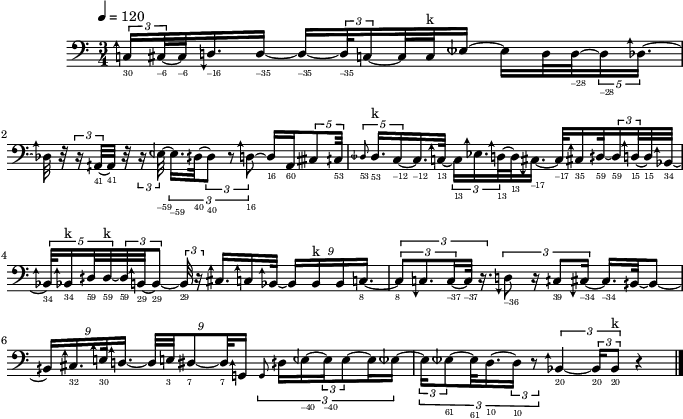

Exiting python, closing all active engines
... stopping maelzel.core


end of score.		   overall amps:  0.69515  0.97192
	   overall samples out of range:        0        0
0 errors in performance
73848 512 sample blks of 64-bit floats written to dac:system:playback


In [25]:
voice2 = Chain(n.clone(offset=struct.timeToBeat(n.offset), dur=struct.beatDelta(n.offset, n.end)) for n in voice)
with Workspace(scorestruct=struct):
    voice2.show()